# 电影数据分析与推荐系统构建：

### 数据来源：Kaggle提供的Internet Movie Database（TMDb）数据集。
参考文档：  
1.https://github.com/Yu-Chiao/TMDb_Movies  
2.https://blog.csdn.net/qinliu0901/article/details/81067080  
3.https://www.kaggle.com/rounakbanik/movie-recommender-systems


### 流程梳理：
1. 准备工作
    1. 数据载入和预览
    1. 数据清洗和加工
    1. 数据筛选
2. 票房 & 评分分析
    1. 概览（票房、变化趋势）
    1. 类型（不同类型影片的数量变化趋势、票房&评分）
    1. 导演（Top 10、票房&评分分布）
    1. 主演（Top 10、票房&评分分布）
3. 排行榜
4. 基于内容的电影推荐
    1. 相似度计算
    1. 电影推荐

## 1.准备工作

#### 1.1加载依赖库

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer

import warnings; warnings.simplefilter('ignore')

#### 1.2加载数据：

In [2]:
# 电影基本信息
md = pd. read_csv('E:/DLLab/movie/movies_metadata.csv')
# 小数据集，方便计算
links_small = pd.read_csv('E:/DLLab/movie/links_small.csv')
# 演员和导演数据
credits = pd.read_csv('E:/DLLab/movie/credits.csv')
# 关键词数据
keywords = pd.read_csv('E:/DLLab/movie/keywords.csv')

In [3]:
# 数据预览
md.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [4]:
#数据的格式
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

In [5]:
md.shape

(45466, 24)

### 1.3数据初步清洗和加工：
数据清洗主要包括查漏补缺、去重、纠错。
* 查漏补缺：数据集中homepage、runtime、tagline有缺失，但它们也不是我们关心的信息，可以忽略。
* 纠错：目前看不出有没有错误，在后续分析中再考虑。
* 去重：movies数据集中的id是每部电影的识别码，以此来看看有没有重复数据：

##### 1.3.1 删除错误的id数据

In [6]:
print('id为空的个数为：'+str(md[md.id.isnull()]['id'].count()))
#首先筛选id错误的数据
print('id格式错误的数据为：')
md[md['id'].apply(lambda x:not x.isdigit())]['id']

id为空的个数为：0
id格式错误的数据为：


19730    1997-08-20
29503    2012-09-29
35587    2014-01-01
Name: id, dtype: object

In [7]:
# 直接删掉这些数据
md = md.drop([19730, 29503, 35587])

##### 1.3.2 转化成小数据集，方便计算

In [8]:
md['id'] = md['id'].astype('int')
links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
md['id'] = md['id'].astype('int')
md=md[md['id'].isin(links_small['tmdbId'])]
md.shape

(9099, 24)

##### 1.3.2电影类别、年份、平均分等数据格式需要处理

###### 1.3.2.1电影类别

In [9]:
# 处理前的数据格式
md.head(1)['genres']

0    [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
Name: genres, dtype: object

In [10]:
# 处理后的数据格式
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
md.head(1)['genres']

0    [Animation, Comedy, Family]
Name: genres, dtype: object

###### 1.3.2.2年份

In [11]:
#电影时间也做处理
# 空数据转化成np.nan，非空数据截取年份
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
#删掉时间为空的数据
def isnat(s):
    if str(s)=='NaT':
        return True
    else:
        return False
myyear=md[md['year'].apply(isnat)]['year']

print("年份为空的数据个数为：%d"%myyear.count())
# 年份没有空数据了，直接转化为int类型
md['year']=md['year'].astype('int')

年份为空的数据个数为：0


###### 1.3.2.2投票人数和分数

In [12]:
print("投票人数为空的数据个数为：%d"%md[md['vote_count'].isnull()]['vote_count'].count())
print("分数为空的数据个数为：%d"%md[md['vote_average'].isnull()]['vote_average'].count())


投票人数为空的数据个数为：0
分数为空的数据个数为：0


In [13]:
# 因为都不为空，直接转化成int类型
md['vote_count']=md['vote_count'].astype('int')
md['vote_average']=md['vote_average'].astype('int')

##### 1.3.3数据筛选：删除评分人数太少的电影

In [14]:
# 删除评分人数太少的电影
md.drop(index=md[md.vote_count < 40]['id'].index,inplace=True)
md.shape

(6232, 25)

##### 1.3.4连接两个数据集credits和keywords

In [15]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

##### 1.3.5对新的数据集的格式进行修改

###### 1.3.5.1budget和revenue转化成数值类型

In [16]:
#budget和revenue转化成数值类型
md['budget']=md['budget'].astype('int')
md['revenue']=md['revenue'].astype('int')

###### 1.3.5.2只获取导演和前三名演员，且将名字换成小写并合并中间空格

In [17]:
#我们只关注导演和前三名演员
md['cast'] = md['cast'].apply(literal_eval)
md['crew'] = md['crew'].apply(literal_eval)
md['keywords'] = md['keywords'].apply(literal_eval)
md['cast_size'] = md['cast'].apply(lambda x: len(x))
md['crew_size'] = md['crew'].apply(lambda x: len(x))

In [18]:
#返回此电影的导演
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [19]:
md['director'] = md['crew'].apply(get_director)

In [20]:
#获取电影的前三名演员
md['cast'] = md['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
md['cast'] = md['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [21]:
md['keywords'] = md['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [22]:
md['cast'] = md['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
md['director'] = md['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))

###### 1.3.5.4处理关键词：提取关键词的主干，并删除出现次数少的关键词

In [23]:
#计算数据中的关键词的频率
s = md.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [24]:
s = s.value_counts()
s[:5]

woman director          320
duringcreditsstinger    317
murder                  315
independent film        300
based on novel          256
Name: keyword, dtype: int64

In [25]:
#删除出现一次的关键词
s = s[s > 1]

In [26]:
#提取单词词干
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [27]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [28]:
md['keywords'] = md['keywords'].apply(filter_keywords)
md['keywords'] = md['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
md['keywords'] = md['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

##### 1.3.6查看当前未处理数据的缺失值个数：

In [29]:
#显示缺失值个数
NAs = pd.DataFrame(md.isnull().sum())
NAs[NAs.sum(axis = 1) > 0].sort_values(by = [0], ascending = False)

,0
belongs_to_collection,4835
homepage,4514
tagline,905


因为缺失值比较多，不统一处理，用到那个属性处理哪个属性的缺失值

##### 1.3.7查看处理完成后的数据：

In [30]:
pd.set_option("display.max_columns",32)
md.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7,5415,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousi, toy, boy, friendship, friend, rival...",13,106,johnlasseter


## 2 数据探索

这个数据集提供了丰富的信息，可以从多种维度进行分析。   

下面我的分析主要是为了回答这个问题：  
怎样的电影更有可能成功？  

成功的定义可以有两种：高票房或者高评分。而影响成功的因素有不少，例如影片类型、导演、主演等，我将对它们逐个进行分析。

### 2.1票房、评分初步分析

#### 2.1.1票房、预算和投资回报率（ROI）变化趋势

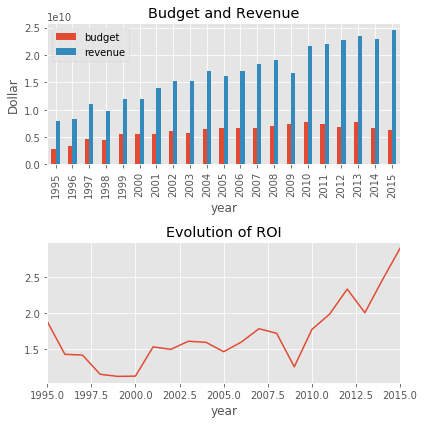

In [31]:
#截取时间
temp=md[md.year >= 1995][md.year <2016].reset_index(drop = True)
temp = temp[['title', 'genres', 'keywords', 'director', 'cast', 'budget', 'revenue', 'popularity', 'vote_average', 'vote_count', 'year']].dropna()
b_r = temp.groupby('year')['budget', 'revenue'].sum()
b_r['ROI'] = (b_r.revenue - b_r.budget) / b_r.budget
#作图：
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
b_r.iloc[:, 0:2].plot(kind='bar', ax=axes[0], title='Budget and Revenue')
axes[0].set_ylabel('Dollar')
b_r.ROI.plot(ax=axes[1], title='Evolution of ROI')
fig.tight_layout()

2000年至2015年间，电影制作的经费投入并没有显著增长，但票房收入呈上升趋势，相应地，ROI从2000年的1.4升到了2015年的2.5，电影行业正处于稳步上升的阶段。

#### 2.1.2评分总体变化趋势

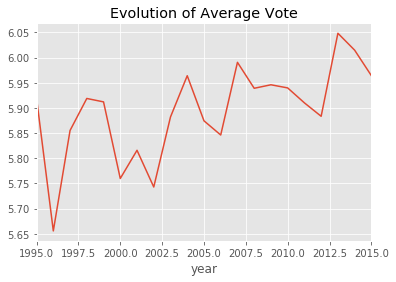

In [32]:
vote_by_year = temp.groupby('year').vote_average.mean()
vote_by_year.plot(title = 'Evolution of Average Vote')

电影评分随年份变化的趋势不明显，总体上在6.25上下小幅度波动。

 ####  2.1.3票房和评分的影响因素（数值型变量）

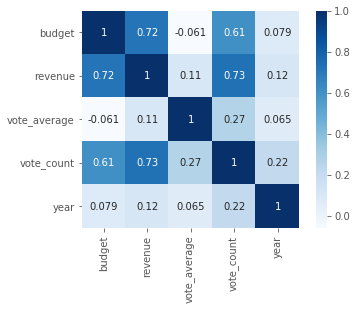

In [33]:
# 热图
sns.heatmap(temp.corr(), annot=True, vmax=1, square=True, cmap="Blues")

票房与预算、评论数的相关性较大，但评论数和票房一样，只能等到电影上映后才知道具体数值。 

评分与票房、预算、热度、评论数的相关性都不大。

### 2.2类别对电影的影响

#### 2.2.1不同类别的占比

In [34]:
#1.不同类型的电影数量
# 将全部的分类加入列表
list1 = []
for i in md['genres']:
    list1.extend(i)
#统计列表中分类的次数，并取前10，索引为次数，值为电影类别
gen_list = pd.Series(list1).value_counts()[:10].sort_values(ascending = False)
gen_df = pd.DataFrame(gen_list)
gen_df.rename(columns = {0:'Total'}, inplace = True)

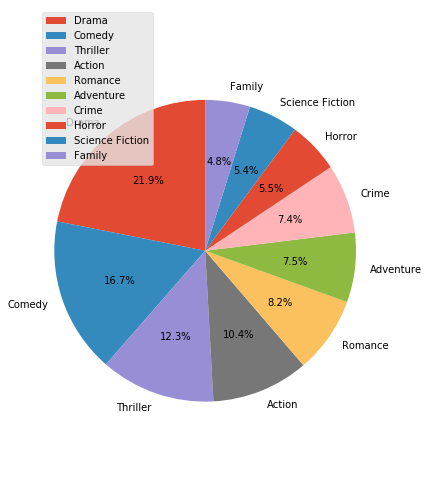

In [35]:
#绘制扇形图
plt.figure(figsize=(6,9))
#定义饼状图的标签，标签是列表
labels = gen_df.index
#每个标签占多大，会自动去算百分比
sizes = gen_df['Total']
patches,l_text,p_text = plt.pie(sizes,labels=labels,labeldistance = 1.1,autopct = '%3.1f%%',shadow = False,startangle = 90,pctdistance = 0.6)
for t in l_text:
    t.set_size=(30)
for t in p_text:
    t.set_size=(20)
# 设置x，y轴刻度一致，这样饼图才能是圆的
plt.axis('equal')
plt.legend()
plt.show()

影片有18种类型，剧情、喜剧、惊悚、动作这4种类型的影片最多，西部片和纪录片最少。
每100部影片中就有约45部属于剧情片，是大家拍摄电影的首选。

#### 2.2.2 不同类别电影数量随时间的变化

In [36]:
#对电影类型去重
l = []
for i in list1:
    if i not in l:
        l.append(i)
year_min=md['year'].min()
#year_min
year_max=md['year'].max()
#year_max
#生成类型为index，年份为列的dataframe，用于每种类型在各年份的数量
year_genr =pd.DataFrame(index=l,columns=range(year_min,year_max+1))
year_genr.fillna(value=0,inplace=True)#初始值为0
intil_y = np.array(md['year'])#用于遍历所有年份
z = 0
for i in md['genres']:
    splt_gen = list(i)
    #每一部电影的所有类型
    for j in splt_gen:
        year_genr.loc[j,intil_y[z]] = year_genr.loc[j,intil_y[z]]+1#计数该类型电影在某一年份的数量
    z+=1
year_genr = year_genr.sort_values(by = 2006, ascending = False)
year_genr = year_genr.iloc[0:10, -49:-1]

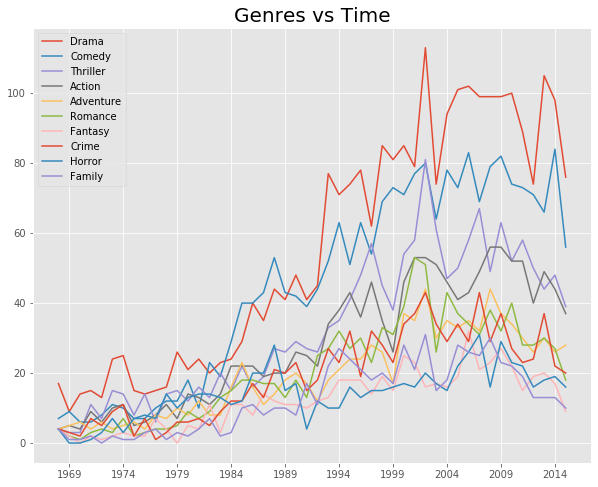

In [37]:
plt.subplots(figsize = (10, 8))
plt.plot(year_genr.T)
plt.title('Genres vs Time',fontsize = 20)
plt.xticks(range(1969, 2015, 5))
plt.legend(year_genr.T)
plt.show()

各种类型的数量占比有一定的浮动，但总体趋势变化不大。
剧情片一直是拍摄电影的首选，近年来还有上涨的态势。
近年来喜剧片的占比下滑，冒险类的占比升高。

#### 2.2.3不同类型影片的票房

In [38]:
def countN(column):
    count = dict()
    for row in column:
        for ele in row:
            if ele in count:
                count[ele] += 1
            else:
                count[ele] = 1
    return count
genres = pd.Series(countN(temp.genres)).sort_values()
movies_by_genres = pd.DataFrame(0, index = genres.index, columns = ['revenue', 'budget', 'vote'])
for i in range(len(temp)):
    for g in temp.genres[i]:
        movies_by_genres.loc[g, 'revenue'] += temp.revenue[i]    #该类影片的总票房
        movies_by_genres.loc[g, 'budget'] += temp.budget[i]    #该类型影片的总均预算
        movies_by_genres.loc[g, 'vote'] += temp.vote_average[i]    #该类型影片的总评分
movies_by_genres = movies_by_genres.div(genres.values, axis=0)
movies_by_genres['ROI'] = (movies_by_genres.revenue - movies_by_genres.budget) / movies_by_genres.budget

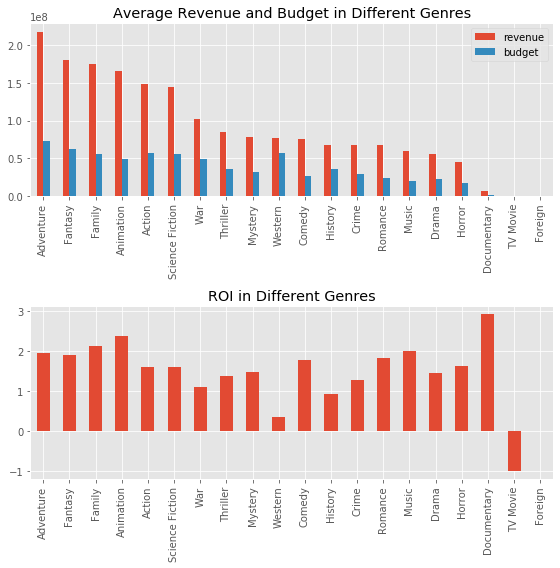

In [39]:
#作图：
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
movies_by_genres.sort_values('revenue', ascending=False)[['revenue', 'budget']].plot(ax=axes[0], kind = 'bar', title='Average Revenue and Budget in Different Genres')
movies_by_genres.sort_values('revenue', ascending=False)['ROI'].plot(ax=axes[1], kind = 'bar', title='ROI in Different Genres')
fig.tight_layout()

票房最高的影片类型是：冒险、科幻、家庭，其次是动画、动作、科幻，它们比其余类型影片的票房高了一大截，当然它们的预算也相对较高。
票房高的影片类型，其投资回报率也是不错的。
剧情片和喜剧虽然热门（影片数量多），但投资回报率表现平平。
投资回报率最高的是较为小众的纪录片，如果预算有限又想获得高收益，纪录片不失为一个好选择。
西部片、历史片和战争片的投资回报率垫底，拍摄此类影片需谨慎。

#### 2.2.4不同类型影片的评分

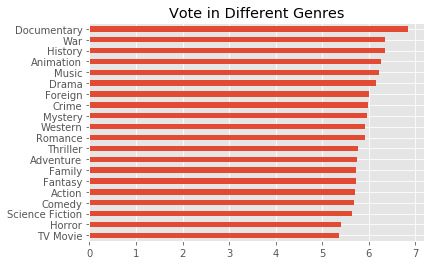

In [40]:
movies_by_genres.sort_values('vote').vote.plot(kind = 'barh', title='Vote in Different Genres')

不同类型影片的评分差距较小，极差约为1分。
纪录片、历史片和战争片的评分位列前三。动作片、喜剧片和恐怖片的评分位列倒数前三。

### 2.3导演对电影的影响

#### 2.3.1导演的票房分布

In [41]:
revenue_of_director = temp.groupby('director').revenue.mean()    #平均票房

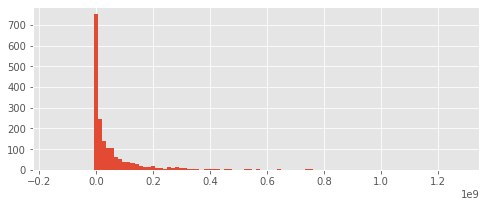

In [42]:
revenue_of_director.hist(bins=100, figsize=(8,3))

典型的长尾分布，极少数导演的吸金能力特别强，下一节我们来看下他们是谁。

#### 2.3.2前十名票房导演是谁

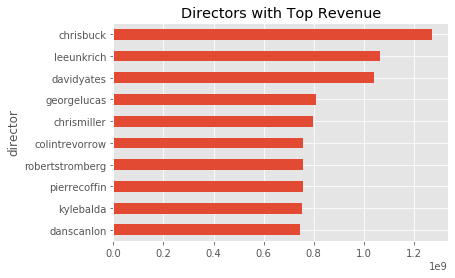

In [43]:
revenue_of_director.sort_values().tail(10).plot(kind = 'barh', title = 'Directors with Top Revenue')

我查询了一下前几个都是动画片导演  
但是我们都知道卡梅隆导演是票房最高的导演，为啥数据中没有呢？

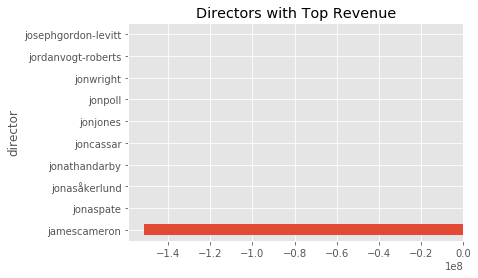

In [44]:
revenue_of_director.sort_values().head(10).plot(kind = 'barh', title = 'Directors with Top Revenue')

我发现原来是卡梅隆导演的电影票房太多超过了，而int32类型的数字最大值为2147483647，超过了这个值之后变成了负值。

#### 2.3.3导演的评分分布

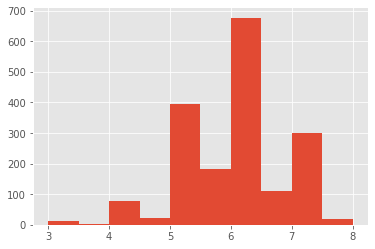

In [45]:
vote_of_director = temp.groupby('director').vote_average.mean()    #平均评分
vote_of_director.hist()

导演的评分近似正态分布，在6-7分之间的人最多。

#### 2.3.4前十名评分导演是谁

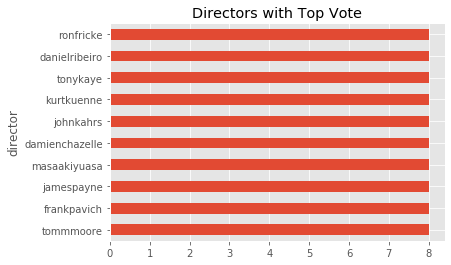

In [46]:
vote_of_director.sort_values().tail(10).plot(kind = 'barh', title = 'Directors with Top Vote')

在评分方面，排名前10的导演差距比较小，他们执导的电影的评分在8分左右。

### 2.4演员对电影的影响

### 2.4.1主演的票房分布

不考虑动画片配音，因此把动画片先排除：

In [47]:
movies_noani = temp[~temp.genres.str.contains('Animation', regex=False)].reset_index(drop = 'True') 

我们只考虑前3位主演，每位主演对票房的贡献按下面的列表来计算：

In [48]:
cast = pd.Series(countN(movies_noani.cast)).sort_values()
movies_by_actors = pd.DataFrame(0, index = cast.index, columns = ['revenue', 'vote'])
#按不同权重统计演员的票房：
r3 = [0.4, 0.3, 0.3]
r2 = [0.6, 0.4]
r1 = [1]
r = [r1, r2, r3]
for i in range(len(movies_noani)):
    actorlist = movies_noani.cast[i][0:3]
    for j in range(len(actorlist)):
        movies_by_actors.loc[actorlist[j], 'revenue'] += movies_noani.revenue[i] * r[len(actorlist)-1][j]    #一个演员的总票房
        movies_by_actors.loc[actorlist[j], 'vote'] += movies_noani.vote_average[i]    #一个演员的总评分
movies_by_actors = movies_by_actors.div(cast.values, axis=0)    #求平均值

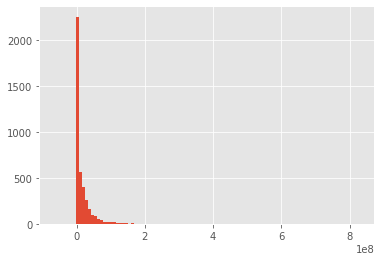

In [49]:
movies_by_actors.revenue.hist(bins=100)

同样是长尾分布，演员之间的票房差距没有导演之间的那么大。

#### 2.4.2票房最高的主演Top 10

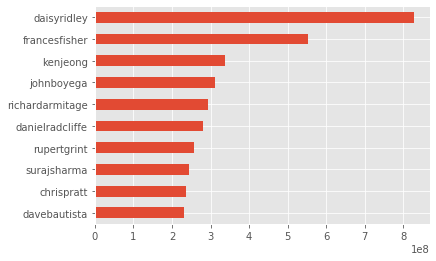

In [50]:
movies_by_actors.revenue.sort_values().tail(10).plot(kind = 'barh')

第一名是星球大战系列主演
第二名是泰坦尼克号主演
阿凡达不是票房最高的吗？我们看一看是否有溢出现象

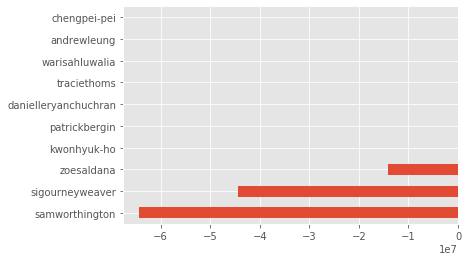

In [51]:
movies_by_actors.revenue.sort_values().head(10).plot(kind = 'barh')

仍然有数值溢出现象，且都出演过阿凡达。

#### 2.4.3演员的评分分布

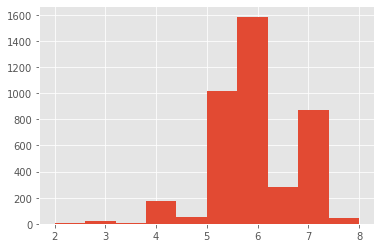

In [52]:
movies_by_actors.vote.hist()

#### 2.4.4评分最高的演员Top 10

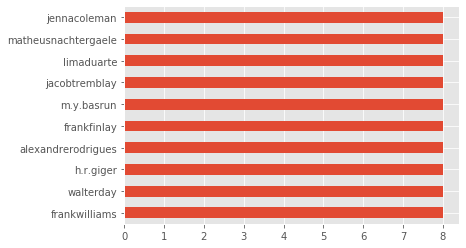

In [53]:
movies_by_actors.vote.sort_values().tail(10).plot(kind = 'barh')

前10名的差距不大。

## 3.构建电影排行版：

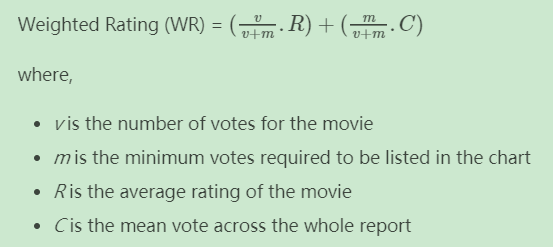

In [54]:
#全部的平均分
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
#
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

6.035470017496421

In [55]:
#求出来公式中的m
m = vote_counts.quantile(0.4)
m

147.0

In [56]:
#从全部数据中筛选出来评分次数不为空且>m
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(3773, 6)

In [57]:
#实现排行公式
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [58]:
#应用排行公式
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [59]:
#进行排序且取出来前250
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [60]:
#显示前15个
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
5059,Inception,2010,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.979694
4564,The Dark Knight,2008,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.976741
5816,Interstellar,2014,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.974520
1613,Fight Club,1999,9678,8,63.8696,[Drama],7.970607
2593,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.968051
171,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.967247
182,The Shawshank Redemption,1994,8358,8,51.6454,"[Drama, Crime]",7.966045
3330,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.965510
204,Forrest Gump,1994,8147,8,48.3072,"[Comedy, Drama, Romance]",7.965181
2927,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,"[Adventure, Fantasy, Action]",7.962919


## 4.基于内容的电影推荐：

前面我们研究了演员、导演、分类对电影成功都有影响，所以我们在此基础上加上关键词属性，基于这4个属性来完成基于内容的电影推荐

In [61]:
md['director'] = md['director'].apply(lambda x: [x,x, x])
#合并全部的因变量
md['soup'] = md['keywords'] +md['cast']+md['director']+md['genres']

md['soup'] = md['soup'].apply(lambda x: ' '.join(x))

* 文本特征提取：
    - 将文本数据转化成特征向量的过程
    - 比较常用的文本特征表示法为词袋法
* 词袋法：
    - 不考虑词语出现的顺序，每个出现过的词汇单独作为一列特征
    - 这些不重复的特征词汇集合为词表
    - 每一个文本都可以在很长的词表上统计出一个很多列的特征向量
    - 如果每个文本都出现的词汇，一般被标记为 停用词 不计入特征向量 
    
CountVectorizer：只考虑词汇在文本中出现的频率

In [62]:
#计算关键词出现的频率
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
#生成矩阵
count_matrix = count.fit_transform(md['soup'])

余弦相似度是通过测量两个向量点积空间夹角的余弦值来判断相似性  

适用于稀疏矩阵计算相似度

In [63]:
#计算余弦相似度
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [64]:
md = md.reset_index()
titles = md['title']
indices = pd.Series(md.index, index=md['title'])

In [65]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = md.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    def weighted_rating(x):
        v = x['vote_count']
        R = x['vote_average']
        return (v / (v + m) * R) + (m / (m + v) * C)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [66]:
improved_recommendations('Avatar')

,title,vote_count,vote_average,year,wr
6035,Star Wars: The Force Awakens,7993,7,2015,6.793854
901,Titanic,7770,7,1997,6.788914
5855,X-Men: Days of Future Past,6155,7,2014,6.744579
5644,Star Trek Into Darkness,4479,7,2013,6.673391
344,Terminator 2: Judgment Day,4274,7,1991,6.661864
654,The Terminator,4208,7,1984,6.657977
618,Aliens,3282,7,1986,6.592220
1908,Predator,2129,7,1987,6.463877
5660,Man of Steel,6462,6,2013,5.946272
5913,Jupiter Ascending,2816,5,2015,5.253946
